In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import os
import gc
import datetime

from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss
from scipy import sparse
from tqdm import tqdm,tqdm_notebook 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
new_transactions = pd.read_csv('./elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('./elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])
for col in ['authorized_flag', 'category_1']:
    historical_transactions[col] = historical_transactions[col].map({'Y':1, 'N':0})
    new_transactions[col]        = new_transactions[col].map({'Y':1, 'N':0})

In [3]:
%%time
## Load training set, test set, basic processing
train = pd.read_csv('./elo-merchant-category-recommendation/train.csv')
test = pd.read_csv('./elo-merchant-category-recommendation/test.csv')

target = train['target']
for df in [train, test]:    
    df['year']  = df['first_active_month'].fillna('0-0').apply(lambda x:int(str(x).split('-')[0]))
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018,3, 1) - df['first_active_month'].dt.date).dt.days
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['month'] = df['first_active_month'].dt.month
    
## Transaction table merge train,test
train_test = pd.concat([train[['card_id','first_active_month']], test[['card_id','first_active_month']] ], axis=0, ignore_index=True)
historical_transactions   = historical_transactions.merge(train_test[['card_id','first_active_month']], on=['card_id'], how='left')
new_transactions = new_transactions.merge(train_test[['card_id','first_active_month']], on=['card_id'], how='left')

CPU times: user 6.43 s, sys: 3.97 s, total: 10.4 s
Wall time: 13.3 s


<Axes: xlabel='target', ylabel='Count'>

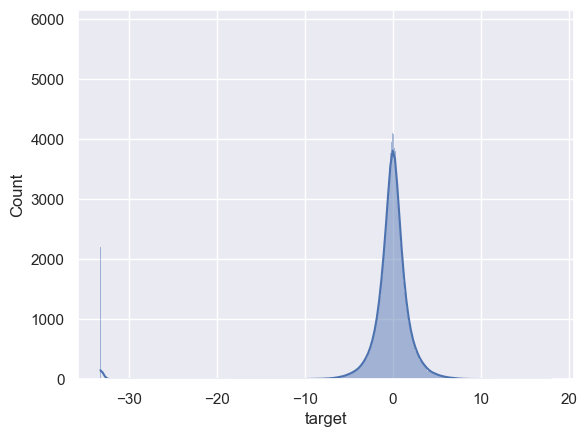

In [4]:
sns.set()
sns.histplot(train['target'], kde=True)

In [5]:
%%time
def month_trans(x): 
    return x // 30

def week_trans(x): 
    return x // 7

## Transaction table preprocessing
def get_expand_common(df_):
    df = df_.copy()
    
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2})
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    df['installments'].replace(-1, np.nan,inplace=True)
    df['installments'].replace(999, np.nan,inplace=True)
    df['installments'].replace(0, 1,inplace=True)
    
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 497.06,8)
    df['purchase_amount'] = df.purchase_amount.apply(lambda x: np.round(x))
    
    df['purchase_date']          =  pd.to_datetime(df['purchase_date']) 
    df['first_active_month']     =  pd.to_datetime(df['first_active_month']) 
    df['purchase_hour']          =  df['purchase_date'].dt.hour
    df['year']                   = df['purchase_date'].dt.year
    df['month']                  =  df['purchase_date'].dt.month
    df['day']                    = df['purchase_date'].dt.day
    df['hour']                   = df['purchase_date'].dt.hour
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['dayofweek']              =  df['purchase_date'].dt.dayofweek
    df['weekend']                =  (df.purchase_date.dt.weekday >=5).astype(int) 
    df                           =  df.sort_values(['card_id','purchase_date']) 
    df['purchase_date_floorday'] =  df['purchase_date'].dt.floor('d')  # Delete time less than day
    
    # Relative time to activation time,0, 1,2,3,... ,max-act
    df['purchase_day_since_active_day']   = df['purchase_date_floorday'] - df['first_active_month']  #ht_card_id_gp['purchase_date_floorday'].transform('min')
    df['purchase_day_since_active_day']   = df['purchase_day_since_active_day'].dt.days  #.astype('timedelta64[D]') 
    df['purchase_month_since_active_day'] = df['purchase_day_since_active_day'].agg(month_trans).values
    df['purchase_week_since_active_day']  = df['purchase_day_since_active_day'].agg(week_trans).values
    
    # Relative time to last day time, 0,1,2,3,... ,max-act
    ht_card_id_gp = df.groupby('card_id')
    df['purchase_day_since_reference_day']   =  ht_card_id_gp['purchase_date_floorday'].transform('max') - df['purchase_date_floorday']
    df['purchase_day_since_reference_day']   =  df['purchase_day_since_reference_day'].dt.days
    
    # A coarse-grained feature (weeks, months passed since most recent purchase)
    df['purchase_week_since_reference_day']  = df['purchase_day_since_reference_day'].agg(week_trans).values
    df['purchase_month_since_reference_day'] = df['purchase_day_since_reference_day'].agg(month_trans).values
    
    df['purchase_day_diff']   =  df['purchase_date_floorday'].shift()
    df['purchase_day_diff']   =  df['purchase_date_floorday'].values - df['purchase_day_diff'].values
    df['purchase_day_diff']   =  df['purchase_day_diff'].dt.days
    df['purchase_week_diff']  =  df['purchase_day_diff'].agg(week_trans).values
    df['purchase_month_diff'] =  df['purchase_day_diff'].agg(month_trans).values 
    
    df['purchase_amount_ddgd_98']  = df['purchase_amount'].values * df['purchase_day_since_reference_day'].apply(lambda x:0.98**x).values
    df['purchase_amount_ddgd_99']  = df['purchase_amount'].values * df['purchase_day_since_reference_day'].apply(lambda x:0.99**x).values    
    df['purchase_amount_wdgd_96']  = df['purchase_amount'].values * df['purchase_week_since_reference_day'].apply(lambda x:0.96**x).values 
    df['purchase_amount_wdgd_97']  = df['purchase_amount'].values * df['purchase_week_since_reference_day'].apply(lambda x:0.97**x).values 
    df['purchase_amount_mdgd_90']  = df['purchase_amount'].values * df['purchase_month_since_reference_day'].apply(lambda x:0.9**x).values
    df['purchase_amount_mdgd_80']  = df['purchase_amount'].values * df['purchase_month_since_reference_day'].apply(lambda x:0.8**x).values 
    
    df = reduce_mem_usage(df)
    
    return df

historical_transactions = get_expand_common(historical_transactions)
new_transactions        = get_expand_common(new_transactions)

Mem. usage decreased to 3192.83 Mb (64.1% reduction)
Mem. usage decreased to 211.55 Mb (64.7% reduction)
CPU times: user 3min 23s, sys: 26.9 s, total: 3min 50s
Wall time: 4min 12s


In [6]:
%%time
## Constructing basic statistical features
def aggregate_transactions(df_, prefix): 
    
    df = df_.copy()
    
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] = df['month_diff'].astype(int)
    df['month_diff'] += df['month_lag']
    
    df['price'] = df['purchase_amount'] / df['installments']
    df['duration'] = df['purchase_amount'] * df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount'] / df['month_diff']
    
    df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1':      ['mean'],
        'category_2':      ['mean'],
        'category_3':      ['mean'],
        'installments':    ['mean', 'max', 'min', 'std'],
        'month_lag':       ['nunique', 'mean', 'max', 'min', 'std'],
        'month':           ['nunique', 'mean', 'max', 'min', 'std'],
        'hour':            ['nunique', 'mean', 'max', 'min', 'std'],
        'weekofyear':      ['nunique', 'mean', 'max', 'min', 'std'],
        'dayofweek':       ['nunique', 'mean'],
        'weekend':         ['mean'],
        'year':            ['nunique'],
        'card_id':         ['size','count'],
        'purchase_date':   ['max', 'min'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std','mean'],
        'price':             ['mean','max','min','std'],
        'duration':          ['mean','min','max','std','skew'],
        'amount_month_ratio':['mean','min','max','std','skew'],
        } 
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        agg_func[col+'_mean'] = ['mean']
    
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(drop=False, inplace=True)
  
    return agg_df
print('generate statistics features...')
auth_base_stat = aggregate_transactions(historical_transactions[historical_transactions['authorized_flag']==1], prefix='auth_')
print('generate statistics features...')
hist_base_stat = aggregate_transactions(historical_transactions[historical_transactions['authorized_flag']==0], prefix='hist_')
print('generate statistics features...')
new_base_stat  = aggregate_transactions(new_transactions, prefix='new_')

generate statistics features...
generate statistics features...
generate statistics features...
CPU times: user 2min 13s, sys: 12.5 s, total: 2min 25s
Wall time: 2min 52s


In [7]:
%%time
def get_quantile(x, percentiles = [0.1, 0.25, 0.75, 0.9]):
    x_len = len(x)
    x = np.sort(x)
    sts_feas = []  
    for per_ in percentiles:
        if per_ == 1:
            sts_feas.append(x[x_len - 1]) 
        else:
            sts_feas.append(x[int(x_len * per_)]) 
    return sts_feas 

def get_cardf_tran(df_, month = 3, prefix = '_'):
    
    df = df_.copy() 
    if prefix == 'hist_cardf_':
        df['month_to_now']  =  (datetime.date(2018, month, 1) - df['purchase_date_floorday'].dt.date).dt.days
    
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] = df['month_diff'].astype(int)
    df['month_diff'] += df['month_lag']
    
    print('*'*30,'Part1, whole data','*'*30)
    cardid_features = pd.DataFrame()
    cardid_features['card_id'] = df['card_id'].unique()   
    print( '*' * 30, 'Traditional Features', '*' * 30)
    ht_card_id_gp = df.groupby('card_id') 
    cardid_features['card_id_cnt'] = ht_card_id_gp['authorized_flag'].count().values
    
    if  prefix == 'hist_cardf_':
        cardid_features['card_id_isau_mean'] = ht_card_id_gp['authorized_flag'].mean().values
        cardid_features['card_id_isau_sum'] = ht_card_id_gp['authorized_flag'].sum().values 
    
    cardid_features['month_diff_mean']   = ht_card_id_gp['month_diff'].mean().values
    cardid_features['month_diff_median'] = ht_card_id_gp['month_diff'].median().values
    
    if prefix == 'hist_cardf_':
        cardid_features['reference_day']           =  ht_card_id_gp['purchase_date_floorday'].max().values
        cardid_features['first_day']               =  ht_card_id_gp['purchase_date_floorday'].min().values 
        cardid_features['activation_day']          =  ht_card_id_gp['first_active_month'].max().values
       
        # first to activation day
        cardid_features['first_to_activation_day']  =  (cardid_features['first_day'] - cardid_features['activation_day']).dt.days
        # activation to reference day 
        cardid_features['activation_to_reference_day']  =  (cardid_features['reference_day'] - cardid_features['activation_day']).dt.days
        # first to last day 
        cardid_features['first_to_reference_day']  =  (cardid_features['reference_day'] - cardid_features['first_day']).dt.days
        # reference day to now  
        cardid_features['reference_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['reference_day'].dt.date).dt.days 
        # first day to now
        cardid_features['first_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['first_day'].dt.date).dt.days 
        
        print('card_id(month_lag, min to reference day):min')
        cardid_features['card_id_month_lag_min'] = ht_card_id_gp['month_lag'].agg('min').values   
        # is_purchase_before_activation,first_to_reference_day_divide_activation_to_reference_day
        cardid_features['is_purchase_before_activation'] = cardid_features['first_to_activation_day'] < 0 
        cardid_features['is_purchase_before_activation'] = cardid_features['is_purchase_before_activation'].astype(int)
        cardid_features['first_to_reference_day_divide_activation_to_reference_day'] = cardid_features['first_to_reference_day']  / (cardid_features['activation_to_reference_day']  + 0.01)
        cardid_features['days_per_count'] = cardid_features['first_to_reference_day'].values / cardid_features['card_id_cnt'].values
   
    if prefix == 'new_cardf_':
        print(' Eight time features, ') 
        cardid_features['reference_day']           =  ht_card_id_gp['reference_day'].last().values
        cardid_features['first_day']               =  ht_card_id_gp['purchase_date_floorday'].min().values 
        cardid_features['last_day']                =  ht_card_id_gp['purchase_date_floorday'].max().values
        cardid_features['activation_day']          =  ht_card_id_gp['first_active_month'].max().values
        # reference to first day
        cardid_features['reference_day_to_first_day']  =  (cardid_features['first_day'] - cardid_features['reference_day']).dt.days
        # reference to last day
        cardid_features['reference_day_to_last_day']  =  (cardid_features['last_day'] - cardid_features['reference_day']).dt.days  
        # first to last day 
        cardid_features['first_to_last_day']  =  (cardid_features['last_day'] - cardid_features['first_day']).dt.days
        # activation to first day 
        cardid_features['activation_to_first_day']  =  (cardid_features['first_day'] - cardid_features['activation_day']).dt.days
        # activation to first day 
        cardid_features['activation_to_last_day']  =  (cardid_features['last_day'] - cardid_features['activation_day']).dt.days
        # last day to now  
        cardid_features['reference_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['reference_day'].dt.date).dt.days 
        # first day to now
        cardid_features['first_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['first_day'].dt.date).dt.days 
        
        print('card_id(month_lag, min to reference day):min')
        cardid_features['card_id_month_lag_max'] = ht_card_id_gp['month_lag'].agg('max').values  
        cardid_features['first_to_last_day_divide_reference_to_last_day'] = cardid_features['first_to_last_day']  / (cardid_features['reference_day_to_last_day']  + 0.01)
        cardid_features['days_per_count'] = cardid_features['first_to_last_day'].values / cardid_features['card_id_cnt'].values
    
    for f in ['reference_day', 'first_day', 'last_day', 'activation_day']:
        try:
            del cardid_features[f]
        except:
            print(f, 'No found!!!')

    print('card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique') 
    for col in tqdm_notebook(['category_1','category_2','category_3','state_id','city_id','installments','merchant_id', 'merchant_category_id','subsector_id','month_lag','purchase_date_floorday']):
        cardid_features['card_id_%s_nunique'%col]            =  ht_card_id_gp[col].nunique().values
        cardid_features['card_id_cnt_divide_%s_nunique'%col] =  cardid_features['card_id_cnt'].values / cardid_features['card_id_%s_nunique'%col].values
         
    print('card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)') 
    for col in tqdm_notebook(['installments','purchase_amount','purchase_amount_ddgd_98','purchase_amount_ddgd_99','purchase_amount_wdgd_96','purchase_amount_wdgd_97','purchase_amount_mdgd_90','purchase_amount_mdgd_80']):
        if col =='purchase_amount':
            for opt in ['sum','mean','std','median','max','min']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values
            
            cardid_features['card_id_' +col+ '_range'] =  cardid_features['card_id_' +col+ '_max'].values - cardid_features['card_id_' +col+ '_min'].values
            percentiles = ht_card_id_gp[col].apply(lambda x:get_quantile(x,percentiles = [0.025, 0.25, 0.75, 0.975])) 

            cardid_features[col + '_2.5_quantile']  = percentiles.map(lambda x:x[0]).values
            cardid_features[col + '_25_quantile'] = percentiles.map(lambda x:x[1]).values
            cardid_features[col + '_75_quantile'] = percentiles.map(lambda x:x[2]).values
            cardid_features[col + '_97.5_quantile'] = percentiles.map(lambda x:x[3]).values
            cardid_features['card_id_' +col+ '_range2'] =  cardid_features[col+ '_97.5_quantile'].values - cardid_features[col+ '_2.5_quantile'].values
            del cardid_features[col + '_2.5_quantile'],cardid_features[col + '_97.5_quantile']
            gc.collect()
        else:
            for opt in ['sum']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values          
    
    print( '*' * 30, 'Pivot Features', '*' * 30)
    print('Count  Pivot') 
#purchase_month_since_reference_day (may be duplicated with month_lag), percentage drop, ignore for now (day of week, merchant_cate, state_id) not very useful installments
    for pivot_col in tqdm_notebook(['category_1','category_2','category_3','month_lag','subsector_id','weekend']): #'city_id',,
    
        tmp     = df.groupby(['card_id',pivot_col])['merchant_id'].count().to_frame(pivot_col + '_count')
        tmp.reset_index(inplace =True)  
         
        tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_count',fill_value=0)
        tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_cnt_pivot_'+ str(col) for col in tmp_pivot.columns]
        tmp_pivot.reset_index(inplace = True)
        cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
      
        if  pivot_col!='weekend' and  pivot_col!='installments':
            tmp            = df.groupby(['card_id',pivot_col])['purchase_date_floorday'].nunique().to_frame(pivot_col + '_purchase_date_floorday_nunique') 
            tmp1           = df.groupby(['card_id'])['purchase_date_floorday'].nunique().to_frame('purchase_date_floorday_nunique') 
            tmp.reset_index(inplace =True)  
            tmp1.reset_index(inplace =True)   
            tmp  = tmp.merge(tmp1, on ='card_id', how='left')
            tmp[pivot_col + '_day_nunique_pct'] = tmp[pivot_col + '_purchase_date_floorday_nunique'].values / tmp['purchase_date_floorday_nunique'].values
         
            tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_day_nunique_pct',fill_value=0)
            tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_day_nunique_pct_'+ str(col) for col in tmp_pivot.columns]
            tmp_pivot.reset_index(inplace = True)
            cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
    
    if prefix == 'new_cardf_':
        
    ######## Spending on the card before it was activated ##############   
        print('*'*30,'Part2， data with time less than activation day','*'*30)
        df_part = df.loc[df.purchase_date < df.first_active_month]

        cardid_features_part = pd.DataFrame()
        cardid_features_part['card_id'] = df_part['card_id'].unique()   
        ht_card_id_part_gp = df_part.groupby('card_id')
        cardid_features_part['card_id_part_cnt'] = ht_card_id_part_gp['authorized_flag'].count().values

        print('card_id(purchase_amount): sum') 
        for col in tqdm_notebook(['purchase_amount']): 
            for opt in ['sum','mean']:
                cardid_features_part['card_id_part_' +col+ '_' + opt] = ht_card_id_part_gp[col].agg(opt).values

        cardid_features = cardid_features.merge(cardid_features_part, on ='card_id', how='left')
        cardid_features['card_id_part_purchase_amount_sum_percent'] = cardid_features['card_id_part_purchase_amount_sum'] / (cardid_features['card_id_purchase_amount_sum'] + 0.01)

    cardid_features = reduce_mem_usage(cardid_features)
    
    new_col_names = []
    for col in cardid_features.columns:
        if col == 'card_id':
            new_col_names.append(col)
        else:
            new_col_names.append(prefix + col)
    cardid_features.columns = new_col_names
    
    return cardid_features
print('auth...')
authorized_transactions = historical_transactions.loc[historical_transactions['authorized_flag'] == 1]
auth_cardf_tran = get_cardf_tran(authorized_transactions, 3, prefix='auth_cardf_')
print('hist...')
hist_cardf_tran = get_cardf_tran(historical_transactions, 3, prefix='hist_cardf_')
print('new...')
reference_days = historical_transactions.groupby('card_id')['purchase_date'].last().to_frame('reference_day')
reference_days.reset_index(inplace = True)
new_transactions = new_transactions.merge(reference_days, on ='card_id', how='left')
new_cardf_tran  = get_cardf_tran(new_transactions, 5, prefix='new_cardf_')

auth...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
reference_day No found!!!
first_day No found!!!
last_day No found!!!
activation_day No found!!!
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased to 112.08 Mb (73.1% reduction)
hist...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
card_id(month_lag, min to reference day):min
last_day No found!!!
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased to 121.08 Mb (72.6% reduction)
new...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
 Eight time features, 
card_id(month_lag, min to reference day):min
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

****************************** Part2， data with time less than activation day ******************************
card_id(purchase_amount): sum


  0%|          | 0/1 [00:00<?, ?it/s]

Mem. usage decreased to 92.65 Mb (73.0% reduction)
CPU times: user 9min 4s, sys: 51.3 s, total: 9min 56s
Wall time: 10min 34s


In [8]:
%%time
def get_cardf_tran_last2(df_, month = 3, prefix = 'last2_'): 
    
    df = df_.loc[df_.month_lag >= -2].copy()
    print('*'*30,'Part1, whole data','*'*30)
    cardid_features = pd.DataFrame()
    cardid_features['card_id'] = df['card_id'].unique()   
    
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] = df['month_diff'].astype(int)
    df['month_diff'] += df['month_lag']
    
    print( '*' * 30, 'Traditional Features', '*' * 30)
    ht_card_id_gp = df.groupby('card_id')
    print(' card id : count')
    cardid_features['card_id_cnt'] = ht_card_id_gp['authorized_flag'].count().values
    
    cardid_features['card_id_isau_mean'] = ht_card_id_gp['authorized_flag'].mean().values 
    cardid_features['card_id_isau_sum']  = ht_card_id_gp['authorized_flag'].sum().values
    
    cardid_features['month_diff_mean']   = ht_card_id_gp['month_diff'].mean().values

    print('card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique') 
    for col in tqdm_notebook(['state_id','city_id','installments','merchant_id', 'merchant_category_id','purchase_date_floorday']):
        cardid_features['card_id_%s_nunique'%col] = ht_card_id_gp[col].nunique().values
        cardid_features['card_id_cnt_divide_%s_nunique'%col] = cardid_features['card_id_cnt'].values / cardid_features['card_id_%s_nunique'%col].values
         
    for col in tqdm_notebook(['purchase_amount','purchase_amount_ddgd_98','purchase_amount_wdgd_96','purchase_amount_mdgd_90','purchase_amount_mdgd_80']): #,'purchase_amount_ddgd_98','purchase_amount_ddgd_99','purchase_amount_wdgd_96','purchase_amount_wdgd_97','purchase_amount_mdgd_90','purchase_amount_mdgd_80']):
        if col =='purchase_amount':
            for opt in ['sum','mean','std','median']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values  
        else:
            for opt in ['sum']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values 
    
    print( '*' * 30, 'Pivot Features', '*' * 30)
    print('Count  Pivot') 
#purchase_month_since_reference_day (may be duplicated with month_lag), percentage drop, ignore for now (dayofweek, merchant_cate, state_id) is not very useful.
    
    for pivot_col in tqdm_notebook(['category_1','category_2','category_3','month_lag','subsector_id','weekend']): #'city_id', 
    
        tmp     = df.groupby(['card_id',pivot_col])['merchant_id'].count().to_frame(pivot_col + '_count')
        tmp.reset_index(inplace =True)  
         
        tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_count',fill_value=0)
        tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_cnt_pivot_'+ str(col) for col in tmp_pivot.columns]
        tmp_pivot.reset_index(inplace = True)
        cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
      
        if  pivot_col!='weekend' and  pivot_col!='installments':
            tmp            = df.groupby(['card_id',pivot_col])['purchase_date_floorday'].nunique().to_frame(pivot_col + '_purchase_date_floorday_nunique') 
            tmp1           = df.groupby(['card_id'])['purchase_date_floorday'].nunique().to_frame('purchase_date_floorday_nunique') 
            tmp.reset_index(inplace =True)  
            tmp1.reset_index(inplace =True)   
            tmp  = tmp.merge(tmp1, on ='card_id', how='left')
            tmp[pivot_col + '_day_nunique_pct'] = tmp[pivot_col + '_purchase_date_floorday_nunique'].values / tmp['purchase_date_floorday_nunique'].values
         
            tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_day_nunique_pct',fill_value=0)
            tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_day_nunique_pct_'+ str(col) for col in tmp_pivot.columns]
            tmp_pivot.reset_index(inplace = True)
            cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
     
    cardid_features = reduce_mem_usage(cardid_features)
    
    new_col_names = []
    for col in cardid_features.columns:
        if col == 'card_id':
            new_col_names.append(col)
        else:
            new_col_names.append(prefix + col)
    cardid_features.columns = new_col_names
    
    return cardid_features  

hist_cardf_tran_last2 = get_cardf_tran_last2(historical_transactions, month = 3, prefix = 'hist_last2_')

****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
 card id : count
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased to 84.45 Mb (74.0% reduction)
CPU times: user 1min 21s, sys: 9.89 s, total: 1min 31s
Wall time: 1min 42s


In [9]:
%%time
def successive_aggregates(df_, prefix = 'levelAB_'):
    df = df_.copy()
    cardid_features = pd.DataFrame()
    cardid_features['card_id'] = df['card_id'].unique()    
    
    level12_nunique = [('month_lag','state_id'),('month_lag','city_id'),('month_lag','subsector_id'),('month_lag','merchant_category_id'),('month_lag','merchant_id'),('month_lag','purchase_date_floorday'),\
                        ('subsector_id','merchant_category_id'),('subsector_id','merchant_id'),('subsector_id','purchase_date_floorday'),('subsector_id','month_lag'),\
                        ('merchant_category_id', 'merchant_id'),('merchant_category_id','purchase_date_floorday'),('merchant_category_id','month_lag'),\
                        ('purchase_date_floorday', 'merchant_id'),('purchase_date_floorday','merchant_category_id'),('purchase_date_floorday','subsector_id')]    
    for col_level1,col_level2 in tqdm_notebook(level12_nunique):  
        
        level1  = df.groupby(['card_id',col_level1])[col_level2].nunique().to_frame(col_level2 + '_nunique')
        level1.reset_index(inplace =True)  

        level2 = level1.groupby('card_id')[col_level2 + '_nunique'].agg(['mean', 'max', 'std'])
        level2 = pd.DataFrame(level2)
        level2.columns = [col_level1 + '_' + col_level2 + '_nunique_' + col for col in level2.columns.values]
        level2.reset_index(inplace = True)
        
        cardid_features = cardid_features.merge(level2, on='card_id', how='left') 
    
    level12_count = ['month_lag','state_id','city_id','subsector_id','merchant_category_id','merchant_id','purchase_date_floorday']
    for col_level in tqdm_notebook(level12_count): 
    
        level1  = df.groupby(['card_id',col_level])['merchant_id'].count().to_frame(col_level + '_count')
        level1.reset_index(inplace =True)  

        level2 = level1.groupby('card_id')[col_level + '_count'].agg(['mean', 'max', 'std'])
        level2 = pd.DataFrame(level2)
        level2.columns = [col_level + '_count_' + col for col in level2.columns.values]
        level2.reset_index(inplace = True)
        
        cardid_features = cardid_features.merge(level2, on='card_id', how='left') 
    
    level12_meansum = [('month_lag','purchase_amount'),('state_id','purchase_amount'),('city_id','purchase_amount'),('subsector_id','purchase_amount'),\
                        ('merchant_category_id','purchase_amount'),('merchant_id','purchase_amount'),('purchase_date_floorday','purchase_amount')]
    for col_level1,col_level2 in tqdm_notebook(level12_meansum): 
    
        level1  = df.groupby(['card_id',col_level1])[col_level2].sum().to_frame(col_level2 + '_sum')
        level1.reset_index(inplace =True)  

        level2 = level1.groupby('card_id')[col_level2 + '_sum'].agg(['mean', 'max', 'std'])
        level2 = pd.DataFrame(level2)
        level2.columns = [col_level1 + '_' + col_level2 + '_sum_' + col for col in level2.columns.values]
        level2.reset_index(inplace = True)

        cardid_features = cardid_features.merge(level2, on='card_id', how='left')           
    
    cardid_features = reduce_mem_usage(cardid_features)
    
    new_col_names = []
    for col in cardid_features.columns:
        if col == 'card_id':
            new_col_names.append(col)
        else:
            new_col_names.append(prefix + col)
    cardid_features.columns = new_col_names
    
    return cardid_features  

print('hist...')
hist_levelAB = successive_aggregates(historical_transactions, prefix = 'hist_levelAB_')

hist...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Mem. usage decreased to 70.16 Mb (66.8% reduction)
CPU times: user 5min 11s, sys: 36.9 s, total: 5min 48s
Wall time: 6min 12s


In [10]:
%%time
print(train.shape)
print(test.shape)
## Merge to training set and test set
print('#_____ Basic Statistical Features')
train = pd.merge(train, auth_base_stat, on='card_id', how='left')
test  = pd.merge(test,  auth_base_stat, on='card_id', how='left')
train = pd.merge(train, hist_base_stat, on='card_id', how='left')
test  = pd.merge(test,  hist_base_stat, on='card_id', how='left')
train = pd.merge(train, new_base_stat , on='card_id', how='left')
test  = pd.merge(test,  new_base_stat , on='card_id', how='left')
print(train.shape)
print(test.shape)
print('#_____ global cardid features')
train = pd.merge(train, auth_cardf_tran, on='card_id', how='left')
test  = pd.merge(test,  auth_cardf_tran, on='card_id', how='left')
train = pd.merge(train, hist_cardf_tran, on='card_id', how='left')
test  = pd.merge(test,  hist_cardf_tran, on='card_id', how='left')
train = pd.merge(train, new_cardf_tran , on='card_id', how='left')
test  = pd.merge(test,  new_cardf_tran , on='card_id', how='left')
print(train.shape)
print(test.shape)
print('#_____ last two months cardid characteristics')
train = pd.merge(train, hist_cardf_tran_last2, on='card_id', how='left')
test  = pd.merge(test,  hist_cardf_tran_last2, on='card_id', how='left')
print(train.shape)
print(test.shape)
print('#_____ Supplementary second order features')
train = pd.merge(train, hist_levelAB, on='card_id', how='left')
test  = pd.merge(test,  hist_levelAB, on='card_id', how='left')
print(train.shape)
print(test.shape)

(201917, 11)
(123623, 10)
#_____ Basic Statistical Features
(201917, 182)
(123623, 181)
#_____ global cardid features
(201917, 705)
(123623, 704)
#_____ last two months cardid characteristics
(201917, 839)
(123623, 838)
#_____ Supplementary second order features
(201917, 929)
(123623, 928)
CPU times: user 5.42 s, sys: 2.7 s, total: 8.12 s
Wall time: 10.2 s


In [13]:
%%time
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()
for f in ['feature_1','feature_2','feature_3']:
    colname = f+'_outliers_mean'
    order_label = train.groupby([f])['outliers'].mean()
    for df in [train, test]:
        df[colname] = df[f].map(order_label)

for df in [train, test]:
    
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
    
    df['card_id_total'] = df['hist_card_id_size']+df['new_card_id_size']
    df['card_id_cnt_total'] = df['hist_card_id_count']+df['new_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['hist_cardf_card_id_purchase_amount_sum']+df['new_cardf_card_id_purchase_amount_sum']
    df['purchase_amount_ratio'] = df['new_cardf_card_id_purchase_amount_sum']/df['hist_cardf_card_id_purchase_amount_sum']
    df['month_diff_ratio'] = df['new_cardf_month_diff_mean']/df['hist_cardf_month_diff_mean']
    df['installments_total'] = df['new_cardf_card_id_installments_sum']+df['auth_cardf_card_id_installments_sum']
    df['installments_ratio'] = df['new_cardf_card_id_installments_sum']/df['auth_cardf_card_id_installments_sum']
    df['price_total'] = df['purchase_amount_total']/df['installments_total']
    df['new_CLV'] = df['new_card_id_count'] * df['new_cardf_card_id_purchase_amount_sum'] / df['new_cardf_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_cardf_card_id_purchase_amount_sum'] / df['hist_cardf_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    # interaction between hist and new data
    df['purchase_amount_ratio_v3'] = df['new_purchase_amount_max']/df['hist_purchase_amount_sum']
    df['purchase_amount_diff_sum'] = df['new_purchase_amount_sum']-df['hist_purchase_amount_sum']
    df['purchase_amount_diff_mean'] = df['new_purchase_amount_mean']-df['hist_purchase_amount_mean']
    df['purchase_amount_diff_max'] = df['new_purchase_amount_max']-df['hist_purchase_amount_max']
    df['purchase_amount_diff_min'] = df['new_purchase_amount_min']-df['hist_purchase_amount_min']
    df['pa_mlag_ratio'] = df['new_purchase_amount_sum']/(df['hist_month_lag_mean'] - 1)
    df['pa_new_hist_ratio'] = df['new_purchase_amount_sum']/(df['hist_purchase_amount_sum'])
    df['pa_new_hist_mean_ratio'] = df['new_purchase_amount_mean']/(df['hist_purchase_amount_mean'] )
    df['pa_new_hist_min_ratio'] = df['new_purchase_amount_min']/(df['hist_purchase_amount_min'] )
    df['pa_new_hist_max_ratio'] = df['new_purchase_amount_max']/(df['hist_purchase_amount_max'] )

CPU times: user 631 ms, sys: 1.5 s, total: 2.13 s
Wall time: 3.38 s


In [14]:
%%time
del_cols = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'new_cardf': 
        del_cols.append(col)
del_cols1 = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'hist_last2_' in col:
        del_cols1.append(col)
del_cols2 = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'auth_cardf' in col:
        del_cols2.append(col)
del_cols3 = []
for col in train.columns:
    if 'merchant_category_id_month_lag_nunique_' in col and '_pivot_supp' in col:
        del_cols3.append(col)
    if 'city_id' in col and '_pivot_supp' in col:
        del_cols3.append(col)
    if 'month_diff' in col and 'hist_last2_' in col:
        del_cols3.append(col)
    if 'month_diff_std' in col or 'month_diff_gap' in col:
        del_cols3.append(col) 
fea_cols = [col for col in train.columns if train[col].dtypes!='object' and train[col].dtypes != '<M8[ns]' and col!='target' not in col and col!='min_num'\
            and col not in del_cols and col not in del_cols1 and col not in del_cols2 and col!='target1' and col!='card_id_cnt_ht_pivot_supp'  and col not in del_cols3]   
print('Before deletion:',train.shape[1])
print('After deletion:',len(fea_cols))

train = train[fea_cols+['target']]
fea_cols.remove('outliers')
test = test[fea_cols]

train.to_csv("train.csv")
test.to_csv("test.csv")

Before deletion: 799
After deletion: 798
CPU times: user 1min 39s, sys: 3.52 s, total: 1min 42s
Wall time: 1min 46s
